In [3]:
import re
import json
import time
import numpy as np
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from itertools import chain
import pydeck as pdk
from bs4 import BeautifulSoup

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pda

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 90% !important; }</style>"))

In [203]:
#!pip install SPARQLWrapper

### SPARQL queries

In [204]:
### Create SPARQL query
### Resource: https://query.wikidata.org/

query1 = """
SELECT ?coordinates ?personLabel ?birthPlaceLabel ?birthDate ?wikipedia
WHERE {
  ?person wdt:P27 wd:Q212;  # Ukrainian nationality
          wdt:P19 ?birthPlace;  # Person has a birthplace
          wdt:P569 ?birthDate.

  ?birthPlace wdt:P625 ?coordinates.  # Get birthplace coordinates if available
  
  ?article schema:about ?person;

  OPTIONAL {
    ?ukWiki schema:about ?person;
            schema:isPartOf <https://uk.wikipedia.org/>.  # Ukrainian Wikipedia article
  }

  OPTIONAL {
    ?enWiki schema:about ?person;
            schema:isPartOf <https://en.wikipedia.org/>.  # English Wikipedia article
  }

  # Choose the Ukrainian Wikipedia link if available, otherwise fall back to English
  BIND(COALESCE(?ukWiki, ?enWiki) AS ?wikipedia)

  # Ensure birthdate is after 1800
  #FILTER(YEAR(?birthDate) >= 2000)

  # Ensure labels are returned in English or Ukrainian
  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk,en". }
}
LIMIT 35000
"""

def get_all_wiki_data(query_template, limit=5000):
    all_results = []
    offset = 0
    
    while True:
        # Add LIMIT and OFFSET to the query
        current_query = query_template + f" LIMIT {limit} OFFSET {offset}"
        #print(current_query)
        
        # Get results for current page
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        sparql.setQuery(current_query)
        sparql.setReturnFormat(JSON)
        sparql.addCustomHttpHeader("User-Agent", "MySPARQLQueryBot/1.0 (your_email@example.com)")
        
        try:
            results = sparql.query().convert()
            #response = sparql.query().response.read().decode("utf-8")  # Decode the response as UTF-8
            #data = json.loads(response)
            #results = data["results"]["bindings"]
            bindings = results["results"]["bindings"]
            
            # If no results returned, we've reached the end
            if not bindings:
                break
                
            all_results.extend(bindings)
            
            # Move to next page
            offset = offset + limit
            print(f"Retrieved {len(bindings)} results (offset {offset})")
            
            # Optional: add a small delay to be nice to the server
            #print("Processed:", offset)
            time.sleep(0.1)
            if offset>60000:
                break
            
        except Exception as e:
            print(f"Error at offset {offset}: {e}")
            continue
    
    return all_results

# Then call the function
#results_uk = get_all_wiki_data(query_uk)

def get_wiki_data(query):

    # Define SPARQL endpoint
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    
    headers = {
        "User-Agent": "MySPARQLQueryBot/1.0 (your_email@example.com)"  # Use your own email for compliance
    }
    
    # Create a SPARQLWrapper instance
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader("User-Agent", "MySPARQLQueryBot/1.0 (your_email@example.com)")
    
    ### Get Responce from WIKI query service
    response = sparql.query().response.read().decode("utf-8")  # Decode the response as UTF-8
    
    ### Convert to JSON
    data = json.loads(response)
    results = data["results"]["bindings"]
    return results

In [205]:
query_other = '''
SELECT ?person ?personLabel ?birthPlaceLabel ?birthDate ?coordinates ?deathPlaceLabel 
        ?coordinates_death ?deathDate ?wikipedia ?sexLabel ?ukraineRelatedEntityLabel
WHERE {
  ?person wdt:P31 wd:Q5.

  # Country/entities to check
  VALUES ?ukraineRelatedEntity {
    wd:Q133356 # Ukrainian Soviet Socialist Republic
    wd:Q243610 # Ukrainian People's Republic
    wd:Q1508143 # –£–∫—Ä–∞—ó–Ω—Å—å–∫–∞ –¥–µ—Ä–∂–∞–≤–∞
    wd:Q457167 # –ó–£–ù–†
    wd:Q950644 # –ö–∞—Ä–ø–∞—Ç—Å—å–∫–∞ –£–∫—Ä–∞—ó–Ω–∞
    wd:Q2418795 # –ó–∞–ø–æ—Ä–æ–∑—å–∫–∞ –°—ñ—á
    wd:Q212439 # Cossack Hetmanate
    wd:Q239502 # –ì–∞–ª–∏—Ü—å–∫–æ –í–æ–ª–∏–Ω—Å—å–∫–µ –ö–Ω—è–∑—ñ–≤—Å—Ç–≤–æ
    wd:Q1108445 # –ö–∏—ó–≤—Å—å–∫–∞ –†—É—Å—å
  }

  # Any of these properties point to one of the target entities
  {
    ?person wdt:P27 ?ukraineRelatedEntity.    # nationality
  }
  UNION {
    ?person wdt:P19 ?placeOfBirth.
    ?placeOfBirth wdt:P17 ?ukraineRelatedEntity.  # –ù–∞—Ä–æ–¥–∂–µ–Ω–∏–π –≤ 
  }
  
  ?wikipedia schema:about ?person;
            schema:isPartOf <https://uk.wikipedia.org/>.

  ?person wdt:P19 ?birthPlace.
    ?birthPlace wdt:P625 ?coordinates.
    
  OPTIONAL { ?person wdt:P20 ?deathPlace. 
                             ?deathPlace wdt:P625 ?coordinates_death.}
  OPTIONAL { ?person wdt:P570 ?deathDate. }
  
  ?person wdt:P569 ?birthDate.
  OPTIONAL { ?person wdt:P21 ?sex. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk". }
}
LIMIT 35000
'''

In [206]:
query_uk1 = '''
SELECT ?personLabel ?birthPlaceLabel ?birthDate ?coordinates ?deathPlaceLabel 
        ?coordinates_death ?deathDate ?wikipedia ?sexLabel ?ukraineRelatedEntityLabel
WHERE {
  ?person wdt:P31 wd:Q5.

  # Country/entities to check
  VALUES ?ukraineRelatedEntity {
    wd:Q212    # Ukraine
  }

  # Any of these properties point to one of the target entities
  {
    ?person wdt:P27 ?ukraineRelatedEntity.    # nationality
  }
  UNION {
    ?person wdt:P19 ?placeOfBirth.
    ?placeOfBirth wdt:P17 ?ukraineRelatedEntity.  # –ù–∞—Ä–æ–¥–∂–µ–Ω–∏–π –≤ 
  }
  
  ?wikipedia schema:about ?person;
            schema:isPartOf <https://uk.wikipedia.org/>.

  ?person wdt:P19 ?birthPlace.
    ?birthPlace wdt:P625 ?coordinates.
    
  OPTIONAL { ?person wdt:P20 ?deathPlace. 
                             ?deathPlace wdt:P625 ?coordinates_death.}
  OPTIONAL { ?person wdt:P570 ?deathDate. }

  ?person wdt:P569 ?birthDate.

  FILTER(YEAR(?birthDate) >= %s && YEAR(?birthDate) < %s)
  
  OPTIONAL { ?person wdt:P21 ?sex. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk". }
}
LIMIT 15000 
'''

In [207]:
query_temp = '''
SELECT ?personLabel ?birthPlaceLabel ?birthDate ?coordinates ?deathPlaceLabel 
        ?coordinates_death ?deathDate ?wikipedia ?sexLabel ?ukraineRelatedEntityLabel
WHERE {
  ?person wdt:P31 wd:Q5.

  # Country/entities to check
  VALUES ?ukraineRelatedEntity {
    wd:Q212    # Ukraine
  }

  # Any of these properties point to one of the target entities
  {
    ?person wdt:P27 ?ukraineRelatedEntity.    # nationality
  }
  UNION {
    ?person wdt:P19 ?placeOfBirth.
    ?placeOfBirth wdt:P17 ?ukraineRelatedEntity.  # –ù–∞—Ä–æ–¥–∂–µ–Ω–∏–π –≤ 
  }
  
  ?wikipedia schema:about ?person;
            schema:isPartOf <https://uk.wikipedia.org/>.

  ?person wdt:P19 ?birthPlace.
    ?birthPlace wdt:P625 ?coordinates.
    
  OPTIONAL { ?person wdt:P20 ?deathPlace. 
                             ?deathPlace wdt:P625 ?coordinates_death.}
  OPTIONAL { ?person wdt:P570 ?deathDate. }

  ?person wdt:P569 ?birthDate.

  FILTER(YEAR(?birthDate) >= %s && YEAR(?birthDate) <= %s)
  
  OPTIONAL { ?person wdt:P21 ?sex. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk". }
}
'''

### Extract data from DataWiki

In [211]:
query1 = query_uk1 % (1000, 1900)
query2 = query_uk1 % (1900, 1925)

### Query result for Ukraine
results_uk1 = get_wiki_data(query=query1)
print('Count1:', len(results_uk1))

### Query result for Ukraine
results_uk2 = get_wiki_data(query=query2)
print('Count2:', len(results_uk2))

Count1: 11460
Count2: 13004


In [23]:
delta = 5
results_uk = []
for i in range(0, 30):
    t1 = 1925+(i*delta)
    t2 = 1930+(i*delta)
    query = query_temp % (t1, t2)

    temp = get_wiki_data(query=query)
    results_uk.extend(temp)
    print(t1, t2,'Count:', len(temp))
    time.sleep(20)
    if t2>2025:
        break

1925 1930 Count: 6404
1930 1935 Count: 5869
1935 1940 Count: 8932
1940 1945 Count: 6027
1945 1950 Count: 8876
1950 1955 Count: 8230
1955 1960 Count: 8776
1960 1965 Count: 8470
1965 1970 Count: 8273
1970 1975 Count: 10902
1975 1980 Count: 11471
1980 1985 Count: 11355
1985 1990 Count: 11220
1990 1995 Count: 10352
1995 2000 Count: 5386
2000 2005 Count: 2092
2005 2010 Count: 270
2010 2015 Count: 29
2015 2020 Count: 4
2020 2025 Count: 0
2025 2030 Count: 0


In [213]:
### Query result for Others
results_others = get_wiki_data(query=query_other)
print('Count others:', len(results_others))

Count others: 5627


In [214]:
results_all = []
results_all.extend(results_uk1)
results_all.extend(results_uk2)
results_all.extend(results_uk)

results_all.extend(results_others)

print('Count:', len(results_all))
print('Count for others:', len(results_others))

Count: 163690
Count for others: 5627


### Preprocess data

In [219]:
# Convert results to a pandas DataFrame
df = pd.DataFrame([
    {
        "Coordinates": item.get("coordinates", {}).get("value", ""),
        "PersonName": item.get("personLabel", {}).get("value", ""),
        "BirthPlace": item.get("birthPlaceLabel", {}).get("value", ""),
        "BirthDate": item.get("birthDate", {}).get("value", ""),
        "DeathDate": item.get("deathDate", {}).get("value", ""),
        "DeathPlace": item.get("deathPlaceLabel", {}).get("value", ""),
        "Coordinates_death": item.get("coordinates_death", {}).get("value", ""),
        "Sex": item.get("sexLabel", {}).get("value", ""),
        "WikipediaURL": item.get("wikipedia", {}).get("value", ""),
        "Affiliation": item.get("ukraineRelatedEntityLabel", {}).get("value", ""),
    }
    for item in results_all
])


### Drop duplicates
df = df.drop_duplicates(['PersonName','WikipediaURL'])

### Save data to Excel
df.to_excel("ukraininans_wiki_data.xlsx", index=False)

print('Dataframe size: ', df.shape)

Dataframe size:  (61088, 10)


In [5]:
df = pd.read_excel("ukraininans_wiki_data.xlsx")

df_death = df[df.DeathPlace!='']
print('Df death size:', df_death.shape[0])

Df death size: 61088


In [6]:
### Columns manipulation
def is_valid_date(date_string):
    try:
        pd.Timestamp(date_string)
        return True
    except ValueError:
        return False

def convert_to_date(date_string):
    try:
        return str(pd.Timestamp(date_string).date())
    except:
        return '–Ω–µ –≤–∫–∞–∑–∞–Ω–æ'

### For bithdate dataframe
df['Lon'] = [float(re.findall(r"Point\((-?\d+.\d+)", x)[0]) for x in df.Coordinates]
df['Lat'] = [float(re.findall(r"Point\(-?\d+.\d+\s+(-?\d+.\d+)", x)[0]) for x in df.Coordinates]
#df['Birthday_check'] = [is_valid_date(x) for x in df.BirthDate]
#df = df[df.Birthday_check==True].drop('Birthday_check', axis=1)
#df['Birthday'] = [str(pd.Timestamp(x).date()) for x in df.BirthDate]
df['Birthday'] = [convert_to_date(x) for x in df.BirthDate]

cord_df = df[['Lat','Lon','PersonName','BirthPlace','Birthday', 'Sex','WikipediaURL','Affiliation']]

In [7]:
import math

def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in kilometers
    R = 6371.0

    lat1, lon1 = map(math.radians, (lat1,lon2))
    lat2, lon2 = map(math.radians, (lat2,lon2))

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in kilometers
    
### For deathday dataframe
df_death.Coordinates_death = df_death.Coordinates_death.fillna('')
df_death = df_death[df_death.Coordinates_death.str.contains('Point')]
df_death['Lon'] = [float(re.findall(r"Point\((-?\d+.\d+)", x)[0]) for x in df_death.Coordinates]
df_death['Lat'] = [float(re.findall(r"Point\(-?\d+.\d+\s+(-?\d+.\d+)", x)[0]) for x in df_death.Coordinates]
df_death['Lon_death'] = [float(re.findall(r"Point\((-?\d+.\d+)", x)[0]) for x in df_death.Coordinates_death]
df_death['Lat_death'] = [float(re.findall(r"Point\(-?\d+.\d+\s+(-?\d+.\d+)", x)[0]) for x in df_death.Coordinates_death]
df_death['Birthday'] = [convert_to_date(x) for x in df_death.BirthDate]
df_death['DeathDate'] = [convert_to_date(x) for x in df_death.DeathDate]
df_death['Distance'] = [haversine(x1,y1, x2,y2) for x1,y1,x2,y2 in zip(df_death.Lat,df_death.Lon, df_death.Lat_death,df_death.Lon_death)]
df_death['SamePlace'] = np.where(df_death.BirthPlace==df_death.DeathPlace, 1, 0)

death_cord_df = df_death[['Lat','Lon','Lat_death','Lon_death','PersonName','Birthday',
                          'BirthPlace','DeathDate','DeathPlace','Distance','SamePlace', 'Sex','WikipediaURL','Affiliation']]

In [8]:
print(cord_df.shape)
cord_df.head()

(61088, 8)


Lat        Lon                          PersonName BirthPlace  \
0  47.664436  36.263172               –ú–∞—Ö–Ω–æ –ù–µ—Å—Ç–æ—Ä –Ü–≤–∞–Ω–æ–≤–∏—á  –ì—É–ª—è–π–ø–æ–ª–µ   
1  49.891944  28.600000                       –î–∂–æ–∑–µ—Ñ –ö–æ–Ω—Ä–∞–¥   –ë–µ—Ä–¥–∏—á—ñ–≤   
2  50.450000  30.523611  –ì—Ä–∏–≥–æ—Ä—ñ–π –í–∞—Å–∏–ª—å–æ–≤–∏—á –®–≤–∞—Ä—Ü-–ë–æ—Å—Ç—É–Ω—ñ—á       –ö–∏—ó–≤   
3  49.000000  32.000000                        –û–ª—å–≥–∞ –ó–µ–≥–ª–µ—Ä    –£–∫—Ä–∞—ó–Ω–∞   
4  50.155000  25.195833                          –õ–µ–æ –ö–∞–Ω–Ω–µ—Ä   –ö–ª–µ–∫–æ—Ç—ñ–≤   

     Birthday       Sex                                       WikipediaURL  \
0  1888-11-07  —á–æ–ª–æ–≤—ñ—á–∞  https://uk.wikipedia.org/wiki/%D0%9C%D0%B0%D1%...   
1  1857-12-03  —á–æ–ª–æ–≤—ñ—á–∞  https://uk.wikipedia.org/wiki/%D0%94%D0%B6%D0%...   
2  1883-12-01  —á–æ–ª–æ–≤—ñ—á–∞  https://uk.wikipedia.org/wiki/%D0%93%D1%80%D0%...   
3  1881-07-31    –∂—ñ–Ω–æ—á–∞  https://uk.wikipedia.org/wiki/%D0%9E%D0%BB%D1%...   
4  1894-06-13  —á–æ–ª–æ–≤—ñ—á–∞  https://uk.wikipedia.org/wiki/%D0%9B%D0%B5%D0%...   

  Affiliation  
0     –£–∫—Ä–∞—ó–Ω–∞  
1     –£–∫—Ä–∞—ó–Ω–∞  
2     –£–∫—Ä–∞—ó–Ω–∞  
3     –£–∫—Ä–∞—ó–Ω–∞  
4     –£–∫—Ä–∞—ó–Ω–∞

### Gender Distribution

In [9]:
gender_freq = pd.DataFrame(cord_df[~cord_df.Sex.isin(['','Q121307100'])].Sex.value_counts()).reset_index()
gender_freq.columns = ['Gender','Count']
gender_freq['Percent'] = 100*gender_freq.Count/gender_freq.Count.sum()
gender_freq

Gender  Count    Percent
0      —á–æ–ª–æ–≤—ñ—á–∞  50268  82.390349
1        –∂—ñ–Ω–æ—á–∞  10740  17.603094
2   —Ç—Ä–∞–Ω—Å-–∂—ñ–Ω–∫–∞      3   0.004917
3  –Ω–µ–±—ñ–Ω–∞—Ä–Ω—ñ—Å—Ç—å      1   0.001639

In [10]:
### Select cases where gender != male or female
cord_df[~cord_df.Sex.isin(['—á–æ–ª–æ–≤—ñ—á–∞','–∂—ñ–Ω–æ—á–∞','','Q121307100', np.nan])]

Lat        Lon     PersonName    BirthPlace    Birthday  \
49347  50.450000  30.523611     –î—ñ–≤–∞ –ú–æ–Ω—Ä–æ          –ö–∏—ó–≤  1978-01-13   
49987  49.000000  32.000000  –†. –ë. –õ–µ–º–±–µ—Ä“ë       –£–∫—Ä–∞—ó–Ω–∞  1976-09-27   
54246  45.503056  32.705000        –ó—ñ–∞–Ω–¥–∂–∞  –ß–æ—Ä–Ω–æ–º–æ—Ä—Å—å–∫–µ  1990-12-12   
57117  48.467500  35.040000   –°—Ç–∞–≤ –°—Ç—Ä–∞—à–∫–æ        –î–Ω—ñ–ø—Ä–æ  1992-09-24   

                Sex                                       WikipediaURL  \
49347   —Ç—Ä–∞–Ω—Å-–∂—ñ–Ω–∫–∞  https://uk.wikipedia.org/wiki/%D0%94%D1%96%D0%...   
49987  –Ω–µ–±—ñ–Ω–∞—Ä–Ω—ñ—Å—Ç—å  https://uk.wikipedia.org/wiki/%D0%A0._%D0%91._...   
54246   —Ç—Ä–∞–Ω—Å-–∂—ñ–Ω–∫–∞      https://uk.wikipedia.org/wiki/Zi_Fa%C3%A1melu   
57117   —Ç—Ä–∞–Ω—Å-–∂—ñ–Ω–∫–∞  https://uk.wikipedia.org/wiki/%D0%A1%D1%82%D0%...   

      Affiliation  
49347     –£–∫—Ä–∞—ó–Ω–∞  
49987     –£–∫—Ä–∞—ó–Ω–∞  
54246     –£–∫—Ä–∞—ó–Ω–∞  
57117     –£–∫—Ä–∞—ó–Ω–∞

### Affiliation Distribution

In [11]:
### Affiliation Distribution
affiliation_freq = pd.DataFrame(cord_df.Affiliation.value_counts()).reset_index()
affiliation_freq.columns = ['Affiliation','Count']
affiliation_freq['Percent'] = 100*affiliation_freq.Count/affiliation_freq.Count.sum()
affiliation_freq

Affiliation  Count    Percent
0                                        –£–∫—Ä–∞—ó–Ω–∞  60367  98.819735
1  –£–∫—Ä–∞—ó–Ω—Å—å–∫–∞ –†–∞–¥—è–Ω—Å—å–∫–∞ –°–æ—Ü—ñ–∞–ª—ñ—Å—Ç–∏—á–Ω–∞ –†–µ—Å–ø—É–±–ª—ñ–∫–∞    416   0.680985
2                  –£–∫—Ä–∞—ó–Ω—Å—å–∫–∞ –ù–∞—Ä–æ–¥–Ω–∞ –†–µ—Å–ø—É–±–ª—ñ–∫–∞    232   0.379780
3           –ó–∞—Ö—ñ–¥–Ω–æ—É–∫—Ä–∞—ó–Ω—Å—å–∫–∞ –ù–∞—Ä–æ–¥–Ω–∞ –†–µ—Å–ø—É–±–ª—ñ–∫–∞     34   0.055657
4                             –£–∫—Ä–∞—ó–Ω—Å—å–∫–∞ –î–µ—Ä–∂–∞–≤–∞     13   0.021281
5                                  –ö–∏—ó–≤—Å—å–∫–∞ –†—É—Å—å     12   0.019644
6                                    –ì–µ—Ç—å–º–∞–Ω—â–∏–Ω–∞     12   0.019644
7                             –ö–∞—Ä–ø–∞—Ç—Å—å–∫–∞ –£–∫—Ä–∞—ó–Ω–∞      2   0.003274

### Birth place ~ death place distance distribution

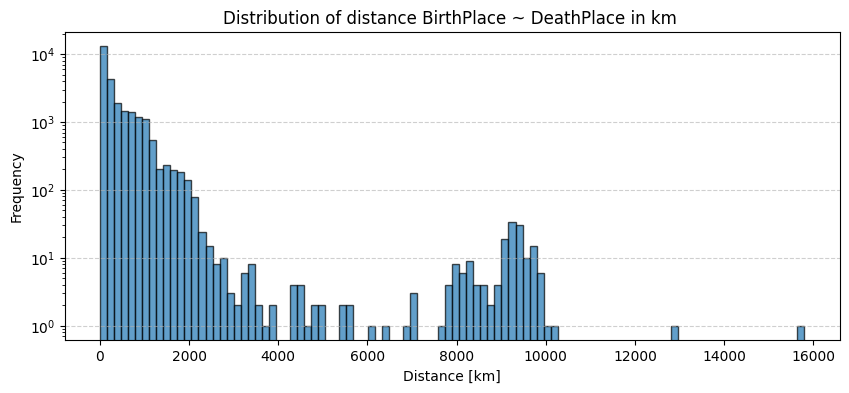

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
ax.hist(death_cord_df["Distance"], bins=100, edgecolor="black", alpha=0.7)
ax.set_yscale('log')
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Frequency")
ax.set_title('Distribution of distance BirthPlace ~ DeathPlace in km ')
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

#### Distribution of SamePlace 
**1 - if birth palce = death place, otherwise = 0**

In [13]:
### Distribution of SamePlace = 1 - if bith palce = death place otherwise 0
same_place_dist = pd.DataFrame(death_cord_df.SamePlace.value_counts(normalize=False)).reset_index(names='SamePlace')
same_place_dist = same_place_dist.rename(columns={'count':'Count'})
same_place_dist['Percent'] = same_place_dist.Count/same_place_dist.Count.sum()
same_place_dist.Percent = same_place_dist.Percent*100
same_place_dist

SamePlace  Count    Percent
0          0  23609  89.333283
1          1   2819  10.666717

In [14]:
### Process SPARQL response and add small noise for observations with same coordinates
mu, sigma = 0, 0.02

cord_df['Temp'] = cord_df.BirthPlace+cord_df.Lon.astype(str)+cord_df.Lat.astype(str)
cord_noise_df = pd.DataFrame()
for place in cord_df.Temp.unique():
    temp = cord_df[cord_df.Temp==place].drop('Temp', axis=1)
    sigma = np.log(len(temp))/150
    temp['Lon2'] =  [x+np.random.normal(mu, sigma) for x in temp.Lon]
    temp['Lat2'] =  [x+np.random.normal(mu, sigma) for x in temp.Lat]
    cord_noise_df = cord_noise_df._append(temp)

cord_noise_df.Lat = cord_noise_df.Lat.round(4)
cord_noise_df.Lon = cord_noise_df.Lon.round(4)
cord_noise_df = cord_noise_df.reset_index(drop=True)

In [230]:
### Process SPARQL response and add small noise for observations with same coordinates for death df
mu, sigma = 0, 0.02

death_cord_df['Temp'] = death_cord_df.DeathPlace+death_cord_df.Lon_death.astype(str)+death_cord_df.Lat_death.astype(str)
death_cord_noise_df = pd.DataFrame()
for place in death_cord_df.Temp.unique():
    temp = death_cord_df[death_cord_df.Temp==place].drop('Temp', axis=1)
    sigma = np.log(len(temp))/150
    temp['Lon2'] =  [x+np.random.normal(mu, sigma) for x in temp.Lon_death]
    temp['Lat2'] =  [x+np.random.normal(mu, sigma) for x in temp.Lat_death]
    death_cord_noise_df = death_cord_noise_df._append(temp)

death_cord_noise_df.Lat2 = death_cord_noise_df.Lat2.round(4)
death_cord_noise_df.Lon2 = death_cord_noise_df.Lon2.round(4)
death_cord_noise_df = death_cord_noise_df.reset_index(drop=True)

### Interactive Visualisation with Pydeck of ukrainians Bith Places

In [232]:
### Create syntetic variable coordinates
birth_cord_df = cord_noise_df[['Lon2','Lat2','PersonName','BirthPlace','Birthday', 'WikipediaURL']]
birth_cord_df['coordinates'] = [[np.round(x,3), np.round(y,3)] for x,y in zip(birth_cord_df.Lon2, birth_cord_df.Lat2)]
birth_cord_df = birth_cord_df.rename(columns={'Lat2':'Latitude', 'Lon2':'Longitude'})


layer = pdk.Layer(
    "ScatterplotLayer",
    data=birth_cord_df,
    pickable=True,
    opacity=0.8,
    stroked=True,
    filled=True,
    extruded=False,
    wireframe=True,
    auto_highlight=True,
    radius_scale=50,        # Lower = smaller change with zoom
    radius_min_pixels=1.5,
    radius_max_pixels=70,
    line_width_min_pixels=1,
    get_position="coordinates",
    get_fill_color=[255, 130, 0],     # Brighter fill
    #get_line_color=[255, 100, 0],     # Warm stroke
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=70,
    latitude=55,
    zoom=2.7,
    min_zoom=0,
    max_zoom=20,
#    pitch=40.5,
#    bearing=-27.36,
)
tooltip = {"html": """<b>–Ü–º'—è:</b>{PersonName}<br /><b>–ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è:</b>{BirthPlace}<br /><b>–î–∞—Ç–∞ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è:</b>{Birthday}<br /><b>
                        –î–æ–≤–≥–æ—Ç–∞:</b>{Longitude}<br /><b>–®–∏—Ä–æ—Ç–∞:</b> {Latitude}
                        """
          }

r_birth = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)

### Save to html
r_birth.to_html("./data/birth_base.html")
_ = None  # prevent Jupyter from rendering anything

### Interactive Visualisation with Pydeck of ukrainians Death Places

In [233]:
 ### Create syntetic variable coordinates
death_cord_df = death_cord_noise_df[['Lon2','Lat2','PersonName','BirthPlace','Birthday','DeathPlace',
                                     'DeathDate','Distance','Sex','SamePlace','WikipediaURL']]
death_cord_df['coordinates'] = [[np.round(x,3), np.round(y,3)] for x,y in zip(death_cord_df.Lon2, death_cord_df.Lat2)]
death_cord_df = death_cord_df.rename(columns={'Lat2':'Latitude', 'Lon2':'Longitude'})


layer = pdk.Layer(
    "ScatterplotLayer",
    data=death_cord_df,
    pickable=True,
    opacity=0.8,
    stroked=True,
    filled=True,
    extruded=False,
    wireframe=True,
    auto_highlight=True,
    radius_scale=50,        # Lower = smaller change with zoom
    radius_min_pixels=1.5,
    radius_max_pixels=70,
    line_width_min_pixels=1,
    get_position="coordinates",
    get_fill_color=[255, 130, 0],     # Brighter fill
    #get_line_color=[255, 100, 0],     # Warm stroke
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=70,
    latitude=55,
    zoom=2.7,
    min_zoom=0,
    max_zoom=20,
#    pitch=40.5,
#    bearing=-27.36,
)

tooltip = {"html": """<b>–Ü–º'—è:</b>{PersonName}<br /><b>–ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è:</b>{BirthPlace}<br /><b>–î–∞—Ç–∞ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è:</b>{Birthday}<br /><b>
            –ú—ñ—Å—Ü–µ —Å–º–µ—Ä—Ç—ñ:</b>{DeathPlace}<br /><b>
            –î–∞—Ç–∞ —Å–º–µ—Ä—Ç—ñ:</b>{DeathDate}<br /><b>
            –î–æ–≤–≥–æ—Ç–∞:</b>{Longitude}<br /><b>–®–∏—Ä–æ—Ç–∞:</b> {Latitude}
            """
          }

r_death = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)

### Save to html
r_death.to_html("./data/death_base.html")
_ = None  # prevent Jupyter from rendering anything

### Statistic Page

In [234]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from plotly.io import to_html

### Locations Distribution

In [ ]:
birthplace_freq = pd.DataFrame(cord_df.BirthPlace.value_counts()).reset_index()
birthplace_freq.columns = ['BirthPlace','Count']
birthplace_freq['Percent'] = 100*birthplace_freq.Count/birthplace_freq.Count.sum()
birthplace_freq = birthplace_freq.head(30)

# Create bar chart (more suitable than histogram for categorical data)
locations_dist_fig = px.bar(
    birthplace_freq,
    x='BirthPlace',
    y='Count',
    text='Count',
    hover_data={'BirthPlace': True, 'Count': True, 'Percent': ':.2f'},
    color_discrete_sequence=['steelblue']
)

# Apply dark theme and style
locations_dist_fig.update_layout(
    height=500,
    margin=dict(t=90, b=20),
    template='plotly_dark',
    #title='T–û–ü 30 –ª–æ–∫–∞—Ü—ñ–π –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—å',
    title=("<span style='font-size:16px;'><b>T–û–ü 30 –ª–æ–∫–∞—Ü—ñ–π –Ω–∞—Ä–æ–¥–∂–µ–Ω—å<br></b></span>"
          "<span style='font-size:12px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Å—Ç–∞—Ç—Ç—ñ –∑ –≤–∫–∞–∑–∞–Ω–∏–º –º—ñ—Å—Ü–µ–º –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è</span>"),
    yaxis_title='–ö—ñ–ª—å–∫—ñ—Å—Ç—å',
    xaxis_title='',
    #yaxis_type="log",
)

locations_dist_fig.update_traces(textposition='outside')

# Create customdata as a 2D array (each row: [Count, Percent])
customdata = np.array(list(zip(birthplace_freq['Count'], birthplace_freq['Percent'])))

# Update hover info
locations_dist_fig.update_traces(
    hovertemplate='–ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è: %{x}<br>–í—ñ–¥—Å–æ—Ç–æ–∫: %{customdata[1]:.2f}%<br>–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{customdata[0]}<extra></extra>',
    customdata=customdata
)

# Show plot
locations_dist_fig.show()

### Distance distribution

In [ ]:
# Create histogram
hist = go.Figure(
    go.Histogram(
        x=death_cord_df["Distance"],
        xbins=dict(
            start=0,                   # ‚õîÔ∏è No negative bins
            end=death_cord_df["Distance"].max(),
            size=100                  # Bin width (adjust as needed)
        ),
        marker_color='steelblue'
    )
)

hist.update_traces(
    hovertemplate=
    '–í—ñ–¥—Å—Ç–∞–Ω—å: %{x} [–∫–º]<br>' +
    '–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{y}<extra></extra>'  # <extra></extra> removes secondary box
)
hist.update_layout(
    height=400,
    margin=dict(t=70, b=20),
    title=("<span style='font-size:20px;'>–†–æ–∑–ø–æ–¥—ñ–ª –≤—ñ–¥—Å—Ç–∞–Ω—ñ –º—ñ–∂ –º—ñ—Å—Ü–µ–º –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —Ç–∞ —Å–º–µ—Ä—Ç—ñ [–∫–º].<br></span>"
           "<span style='font-size:14px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Ç—ñ —Å—Ç–æ—Ä—ñ–Ω–∫–∏ –í—ñ–∫—ñ–ø–µ–¥—ñ—ó, –Ω–∞ —è–∫–∏—Ö –±—É–ª–æ –≤–∫–∞–∑–∞–Ω–æ –º—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ –≤—ñ–¥–ø–æ–≤—ñ–¥–Ω–æ.</span>"),
    yaxis_title="–ö—ñ–ª—å–∫—ñ—Å—Ç—å [log]",
    xaxis_title='–í—ñ–¥—Å—Ç–∞–Ω—å [–∫–º]',
    yaxis_type="log",
    title_font=dict(size=15),  # Chart title font size
    font=dict(size=10),
)
hist.update_layout(template="plotly_dark")

### Pie Charts

In [237]:
### Sex distribution
cord_df.Sex = cord_df.Sex.fillna('')
sex_dist = pd.DataFrame(cord_df[(cord_df.Sex!='') & (~cord_df.Sex.str.contains('Q'))].Sex.value_counts(normalize=False)).reset_index(names='Sex')
sex_dist = sex_dist.rename(columns={'count':'Count'})
sex_dist['Percent'] = sex_dist.Count/sex_dist.Count.sum()
sex_dist.Percent = (sex_dist.Percent*100).round(4)

pie_sex = px.pie(
    sex_dist,
    names="Sex",
    values="Percent",
    title=("<span style='font-size:20px;'>P–æ–∑–ø–æ–¥—ñ–ª –∑–∞ –≥–µ–Ω–¥–µ—Ä–æ–º —è–∫—ñ –≤–∑—è–ª–∏ —É—á–∞—Å—Ç—å –≤ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—ñ<br></span>"
           "<span style='font-size:14px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Ç—ñ —Å—Ç–∞—Ç—Ç—ñ –ª—é–¥–µ–π –≤ —è–∫–∏—Ö –≤–∫–∞–∑–∞–Ω–æ —Å—Ç–∞—Ç—å, –º—ñ—Å—Ü–µ —ñ –¥–∞—Ç—É –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è</span>"),
    hover_data={"Percent": True, "Sex": False, "Count": True}
)

pie_sex.update_traces(
    hovertemplate='–ì–µ–Ω–¥–µ—Ä: %{label}<br>–í—ñ–¥—Å–æ—Ç–æ–∫: %{percent}%<br>–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{customdata[0]}<extra></extra>',
    customdata=sex_dist["Count"]  # Pass 'Count' column to customdata
)


pie_sex.update_layout(
    margin=dict(t=70, b=20),
    template="plotly_dark",
    title_font=dict(size=15),  # Chart title font size
    font=dict(size=10),
)
_ = None  # prevent Jupyter from rendering anything
#pie_sex.show()

In [238]:
### Distribution of same place of birth and death or not
same_place_dist["SamePlace_cat"] = same_place_dist["SamePlace"].map({1: "–ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ –æ–¥–∏–Ω–∞–∫–æ–≤—ñ", 0: "–ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ —Ä—ñ–∑–Ω—ñ"})

pie_same_place = px.pie(
    same_place_dist,
    names="SamePlace_cat",
    values="Percent",
    title="P–æ–∑–ø–æ–¥—ñ–ª –ª—é–¥–µ–π —è–∫—ñ –Ω–∞—Ä–æ–¥–∏–ª–∏—Å—å —ñ –ø–æ–º–µ—Ä–ª–∏ –≤ –æ–¥–Ω–æ–º—É —ñ —Ç–æ–º—É –∂ –º—ñ—Å—Ü—ñ",
    color_discrete_sequence=["steelblue", "orange"],
    hover_data={"Percent": True, "SamePlace_cat": False, "Count": True}
)

pie_same_place.update_traces(
    customdata=same_place_dist["Count"],
    hovertemplate='–ö–∞—Ç–µ–≥–æ—Ä—ñ—è: %{label}<br>–í—ñ–¥—Å–æ—Ç–æ–∫ –ª—é–¥–µ–π: %{percent}<br>–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{customdata[0]}<extra></extra>'

)

pie_same_place.update_layout(
    margin=dict(t=70, b=20),
    title_font=dict(size=15),  # Chart title font size
    font=dict(size=10),
    template="plotly_dark"
)
_ = None  # prevent Jupyter from rendering anything
#pie_same_place.show()

In [ ]:
# --- Create subplot with two pie areas ---
pie_combined = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
)

# --- Pie 1: Sex Distribution ---
pie_combined.add_trace(
    go.Pie(
        labels=sex_dist["Sex"],
        values=sex_dist["Percent"],
        customdata=sex_dist["Count"],
        name="–ì–µ–Ω–¥–µ—Ä",
        hovertemplate='–ì–µ–Ω–¥–µ—Ä: %{label}<br>–í—ñ–¥—Å–æ—Ç–æ–∫: %{percent}%<br>–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{customdata[0]}<extra></extra>',
        showlegend=True
    ),
    row=1, col=1
)

# --- Pie 2: Same Place Distribution ---
pie_combined.add_trace(
    go.Pie(
        labels=same_place_dist["SamePlace_cat"],
        values=same_place_dist["Percent"],
        customdata=same_place_dist["Count"],
        marker=dict(colors=["steelblue", "orange"]),
        name="–ú—ñ—Å—Ü–µ",
        hovertemplate='–ö–∞—Ç–µ–≥–æ—Ä—ñ—è: %{label}<br>–í—ñ–¥—Å–æ—Ç–æ–∫ –ª—é–¥–µ–π: %{percent}<br>–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{customdata[0]}<extra></extra>',
        showlegend=True
    ),
    row=1, col=2
)

# --- Add scalable annotations for titles ---
pie_combined.update_layout(
    annotations=[
        dict(
            #text="<b>P–æ–∑–ø–æ–¥—ñ–ª –∑–∞ –≥–µ–Ω–¥–µ—Ä–æ–º</b><br><span style='font-size:11px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Å—Ç–∞—Ç—Ç—ñ –∑ –≤–∫–∞–∑–∞–Ω–æ—é —Å—Ç–∞—Ç—Ç—é, –º—ñ—Å—Ü–µ–º —ñ –¥–∞—Ç–æ—é –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è</span>",
            text="<span style='font-size:16px;'><b>P–æ–∑–ø–æ–¥—ñ–ª –∑–∞ –≥–µ–Ω–¥–µ—Ä–æ–º<br></b></span><span style='font-size:12px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Å—Ç–∞—Ç—Ç—ñ —ñ–∑ –≤–∫–∞–∑–∞–Ω–∏–º –≥–µ–Ω–¥–µ—Ä–æ–º, –º—ñ—Å—Ü–µ–º —ñ –¥–∞—Ç–æ—é –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è</span>",
            x=0.25, y=1.12, xref='paper', yref='paper',
            showarrow=False, font=dict(size=12), align="center",
            xanchor="center"
        ),
        dict(
            #text="<b>P–æ–∑–ø–æ–¥—ñ–ª –ª—é–¥–µ–π —è–∫—ñ –Ω–∞—Ä–æ–¥–∏–ª–∏—Å—å —ñ –ø–æ–º–µ—Ä–ª–∏ –≤ –æ–¥–Ω–æ–º—É –º—ñ—Å—Ü—ñ —á–∏ –≤ —ñ–Ω—à–æ–º—É</b><br><span style='font-size:12px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Å—Ç–∞—Ç—Ç—ñ –∑ –≤–∫–∞–∑–∞–Ω–∏–º –º—ñ—Å—Ü–µ–º –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —Ç–∞ —Å–º–µ—Ä—Ç—ñ</span>",
            text="<span style='font-size:16px;'><b>–ü–æ—Ä—ñ–≤–Ω—è–ª—å–Ω–∏–π –∞–Ω–∞–ª—ñ–∑ —Å–ø—ñ–≤–ø–∞–¥—ñ–Ω–Ω—è –º—ñ—Å—Ü—è –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —Ç–∞ —Å–º–µ—Ä—Ç—ñ<br></b></span><span style='font-size:12px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Å—Ç–∞—Ç—Ç—ñ —ñ–∑ –≤–∫–∞–∑–∞–Ω–∏–º –º—ñ—Å—Ü–µ–º –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —Ç–∞ —Å–º–µ—Ä—Ç—ñ</span>",
            x=0.75, y=1.12, xref='paper', yref='paper',
            showarrow=False, font=dict(size=12), align="center",
            xanchor="center"
        ),
    ],
    template="plotly_dark",
    margin=dict(t=110, b=10),
    font=dict(size=10)
)

### Horizontal legend
#pie_combined.update_layout(
#    legend=dict(
#        orientation="h",
#        yanchor="bottom",
#        y=-0.15,
#        xanchor="center",
#        x=0.5
#    )
#)

In [240]:
### Create dataframe by gender for detecting distribution of same place birth and death or no
same_place_sex_dist = death_cord_df[death_cord_df.Sex.isin(['—á–æ–ª–æ–≤—ñ—á–∞','–∂—ñ–Ω–æ—á–∞'])][['Sex','SamePlace']]
same_place_sex_dist['Count'] = 1
same_place_sex_dist = same_place_sex_dist.groupby(['Sex','SamePlace'], as_index=False).sum()
same_place_sex_dist['Count_sex'] = same_place_sex_dist.groupby('Sex')['Count'].transform('sum')
same_place_sex_dist['Percent'] = 100*same_place_sex_dist.Count/same_place_sex_dist.Count_sex
same_place_sex_dist = same_place_sex_dist.drop(['Count_sex'], axis=1)
same_place_sex_dist["SamePlace_cat"] = same_place_sex_dist["SamePlace"].map({1: "–ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ –æ–¥–∏–Ω–∞–∫–æ–≤—ñ", 
                                                                             0: "–ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ —Ä—ñ–∑–Ω—ñ"})
same_place_sex_dist

Sex  SamePlace  Count    Percent                        SamePlace_cat
0    –∂—ñ–Ω–æ—á–∞          0   2471  83.620981      –ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ —Ä—ñ–∑–Ω—ñ
1    –∂—ñ–Ω–æ—á–∞          1    484  16.379019  –ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ –æ–¥–∏–Ω–∞–∫–æ–≤—ñ
2  —á–æ–ª–æ–≤—ñ—á–∞          0  21114  90.042219      –ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ —Ä—ñ–∑–Ω—ñ
3  —á–æ–ª–æ–≤—ñ—á–∞          1   2335   9.957781  –ú—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ —Å–º–µ—Ä—Ç—ñ –æ–¥–∏–Ω–∞–∫–æ–≤—ñ

In [ ]:
### Create a pie chart by gender
pie_same_place_sex = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=["–ñ—ñ–Ω–∫–∏", "–ß–æ–ª–æ–≤—ñ–∫–∏"])

# Filter and add pie for each group
for i, sex_label in enumerate(same_place_sex_dist["Sex"].unique()):
    sub_df = same_place_sex_dist[same_place_sex_dist["Sex"] == sex_label]
    pie_same_place_sex.add_trace(
        go.Pie(labels=sub_df["SamePlace_cat"],
               values=sub_df["Percent"],
                customdata=sub_df["Count"],
                name=sex_label,
                marker=dict(colors=["steelblue", "orange"]), 
                hovertemplate='<br>–í—ñ–¥—Å–æ—Ç–æ–∫: %{percent}<br>–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{customdata}<extra></extra>'),
        row=1, col=i+1
    )

# Customize layout
pie_same_place_sex.update_layout(
    margin=dict(t=100, b=20),
    #title="P–æ–∑–ø–æ–¥—ñ–ª –ª—é–¥–µ–π —è–∫—ñ –Ω–∞—Ä–æ–¥–∏–ª–∏—Å—å —ñ –ø–æ–º–µ—Ä–ª–∏ –≤ –æ–¥–Ω–æ–º—É —ñ —Ç–æ–º—É –º—ñ—Å—Ü—ñ –∑–∞ —Å—Ç–∞—Ç—Ç—é",
    title={
    "text": "<span style='font-size:16px;'><b>–ü–æ—Ä—ñ–≤–Ω—è–ª—å–Ω–∏–π –∞–Ω–∞–ª—ñ–∑ —Å–ø—ñ–≤–ø–∞–¥—ñ–Ω–Ω—è –º—ñ—Å—Ü—è –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —Ç–∞ —Å–º–µ—Ä—Ç—ñ –ø–æ –≥–µ–Ω–¥–µ—Ä—É<br></b></span><span style='font-size:12px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Å—Ç–∞—Ç—Ç—ñ —ñ–∑ –≤–∫–∞–∑–∞–Ω–∏–º –º—ñ—Å—Ü–µ–º –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —Ç–∞ —Å–º–µ—Ä—Ç—ñ</span>",
    "x": 0.5,  # Center the title
    "xanchor": "center",
    "font": dict(size=15)
    },
    template="plotly_dark",
    title_font=dict(size=15),  # Chart title font size
    font=dict(size=10),
)

pie_same_place_sex.show()

In [242]:
### Create a dataframe with rounded birthdate for creatiog scatter plot

# Filter and prepare birth data
birth_scatter_plot = cord_df[cord_df.Birthday != '–Ω–µ –≤–∫–∞–∑–∞–Ω–æ'][['Birthday']]
birth_scatter_plot['Count'] = 1
birth_scatter_plot.Birthday = pd.to_datetime(birth_scatter_plot.Birthday, errors='coerce')

# Drop invalid dates
birth_scatter_plot = birth_scatter_plot.dropna(subset=['Birthday'])

# Round to month and extract year
birth_scatter_plot['Round_birthday'] = birth_scatter_plot['Birthday'] + pd.offsets.MonthBegin(-1)
birth_scatter_plot['Round_birthday'] = birth_scatter_plot['Round_birthday'].dt.date
birth_scatter_plot['Year'] = birth_scatter_plot['Birthday'].dt.year

# Monthly data
monthly_counts = birth_scatter_plot[['Round_birthday', 'Count']].groupby('Round_birthday', as_index=False).sum()

# Yearly data
yearly_counts = birth_scatter_plot.groupby('Year', as_index=False)['Count'].sum()
yearly_counts['Year_date'] = yearly_counts['Year'].apply(lambda y: date(y, 1, 1))

In [ ]:
# Create subplot figure with secondary y-axis
scatter_birth = make_subplots(specs=[[{"secondary_y": True}]])

# Monthly scatter plot
scatter_birth.add_trace(
    go.Scatter(
        x=monthly_counts["Round_birthday"],
        y=monthly_counts["Count"],
        mode='markers',
        name='–ú—ñ—Å—è—á–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å',
        marker=dict(color='orange', size=5),
        opacity=0.8
    ),
    secondary_y=False
)

# Transparent yearly bar chart
scatter_birth.add_trace(
    go.Bar(
        x=yearly_counts['Year_date'],
        y=yearly_counts['Count'],
        name='–†—ñ—á–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å',
        marker=dict(color='steelblue'),
        opacity=0.4
    ),
    secondary_y=True
)

# Update layout
scatter_birth.update_layout(
    title=(
        "<span style='font-size:20px;'>–Ü—Å—Ç–æ—Ä–∏—á–Ω–∏–π —Ä–æ–∑–ø–æ–¥—ñ–ª –¥–∞—Ç –Ω–∞—Ä–æ–¥–∂–µ–Ω—å –ª—é–¥–µ–π —ñ–∑ –≤—Å—ñ—Ö –¥–æ—Å—Ç—É–ø–Ω–∏—Ö —Å—Ç–æ—Ä—ñ–Ω–æ–∫ –í—ñ–∫—ñ–ø–µ–¥—ñ—ó —è–∫—ñ –≤–¥–∞–ª–æ—Å—å –≤–∏—è–≤–∏—Ç–∏<br></span>"
        "<span style='font-size:14px;'>–ú—ñ—Å—è—á–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å + —Ä—ñ—á–Ω–∞ –≥—ñ—Å—Ç–æ–≥—Ä–∞–º–∞ –Ω–∞ –¥—Ä—É–≥—ñ–π –æ—Å—ñ</span>"
    ),
    template="plotly_dark",
    margin=dict(t=70, b=30),
    font=dict(size=10),
    barmode='overlay'
)

# Axis labels
scatter_birth.update_xaxes(title_text="–î–∞—Ç–∞ –ù–∞—Ä–æ–¥–∂–µ–Ω–Ω—è")
scatter_birth.update_yaxes(title_text="–ú—ñ—Å—è—á–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å", secondary_y=False)
scatter_birth.update_yaxes(title_text="–†—ñ—á–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å", secondary_y=True)

scatter_birth.show()

### Life expectancy distribution

In [244]:
### Calculate Life Expectancy

life_expectancy = death_cord_df[['Sex','Birthday','DeathDate']]
life_expectancy['Birthday'] = pd.to_datetime(life_expectancy['Birthday'], errors='coerce')
life_expectancy['DeathDate'] = pd.to_datetime(life_expectancy['DeathDate'], errors='coerce')

life_expectancy = life_expectancy.dropna(subset=['Birthday', 'DeathDate'])

# Calculate lifespan in years
life_expectancy['Lifespan'] = (life_expectancy['DeathDate'] - life_expectancy['Birthday']).dt.days / 365.25
life_expectancy['Lifespan'] = life_expectancy['Lifespan'].round(1)
life_expectancy['Year'] = life_expectancy.DeathDate.dt.year
life_expectancy.head()

Sex   Birthday  DeathDate  Lifespan  Year
0  —á–æ–ª–æ–≤—ñ—á–∞ 1888-11-07 1934-07-25      45.7  1934
1  —á–æ–ª–æ–≤—ñ—á–∞ 1867-12-06 1933-11-07      65.9  1933
2  —á–æ–ª–æ–≤—ñ—á–∞ 1873-02-19 1939-09-27      66.6  1939
3  —á–æ–ª–æ–≤—ñ—á–∞ 1898-10-23 1976-02-10      77.3  1976
4  —á–æ–ª–æ–≤—ñ—á–∞ 1850-01-01 1889-01-29      39.1  1889

In [ ]:
import plotly.graph_objects as go
import numpy as np

step = 40
year_min = int(life_expectancy['Year'].min())
year_max = int(life_expectancy['Year'].max()) - step + 1

intervals = [(1600, 1910), (1911, 1960), (1961, 2013), (2014, 2025), ("all", "all")]

life_exp_fig = go.Figure()
all_shapes = []

# —Å—Ç–≤–æ—Ä–∏–º–æ —Å–ø–∏—Å–∫–∏ –¥–ª—è –º–µ–¥—ñ–∞–Ω, —â–æ–± –¥–æ–¥–∞—Ç–∏ –ª–µ–≥–µ–Ω–¥—É
median_lines = []

for i, (start, end) in enumerate(intervals):
    if start == "all":
        filtered_df = life_expectancy
        label = "–í—Å—ñ —Ä–æ–∫–∏"
    else:
        filtered_df = life_expectancy[
            (life_expectancy['Year'] >= start) & (life_expectancy['Year'] <= end)
        ]
        label = f"{start}-{end}"

    # —á–æ–ª–æ–≤—ñ—á–∞
    male_data = filtered_df[filtered_df['Sex'] == '—á–æ–ª–æ–≤—ñ—á–∞']['Lifespan']
    male_median = np.median(male_data)
    life_exp_fig.add_trace(go.Histogram(
        x=male_data,
        name=f'–ß–æ–ª–æ–≤—ñ—á–∞ ({label})',
        marker_color='steelblue',
        opacity=0.7,
        visible=(i == len(intervals) - 1),
        xbins=dict(start=0, end=life_expectancy["Lifespan"].max(), size=1)
    ))
    all_shapes.append(dict(
        type="line",
        x0=male_median, x1=male_median,
        y0=0, y1=1, xref='x', yref='paper',
        line=dict(color='steelblue', dash='dash')
    ))
    # –¥–æ–¥–∞–º–æ ‚Äú–ø—Ä–∏—Ö–æ–≤–∞–Ω–∏–π‚Äù —Å–ª—ñ–¥ –¥–ª—è –ª–µ–≥–µ–Ω–¥–∏
    median_lines.append(go.Scatter(
        x=[male_median, male_median],
        y=[0, life_expectancy["Lifespan"].max()/10],  # –∫–æ—Ä–æ—Ç–∫–∞ –ª—ñ–Ω—ñ—è, –∞–±–∏ –Ω–µ –∑–∞–≤–∞–∂–∞—Ç–∏
        mode='lines',
        line=dict(color='steelblue', dash='dash'),
        showlegend=True,
        name='–ú–µ–¥—ñ–∞–Ω–∞ (–ß–æ–ª–æ–≤—ñ—á–∞)',
        visible=(i == len(intervals) - 1)
    ))

    # –∂—ñ–Ω–æ—á–∞
    female_data = filtered_df[filtered_df['Sex'] == '–∂—ñ–Ω–æ—á–∞']['Lifespan']
    female_median = np.median(female_data)
    life_exp_fig.add_trace(go.Histogram(
        x=female_data,
        name=f'–ñ—ñ–Ω–æ—á–∞ ({label})',
        marker_color='tomato',
        opacity=0.8,
        visible=(i == len(intervals) - 1),
        xbins=dict(start=0, end=life_expectancy["Lifespan"].max(), size=2)
    ))
    all_shapes.append(dict(
        type="line",
        x0=female_median, x1=female_median,
        y0=0, y1=1, xref='x', yref='paper',
        line=dict(color='tomato', dash='dash')
    ))
    median_lines.append(go.Scatter(
        x=[female_median, female_median],
        y=[0, life_expectancy["Lifespan"].max()/10],
        mode='lines',
        line=dict(color='tomato', dash='dash'),
        showlegend=True,
        name='–ú–µ–¥—ñ–∞–Ω–∞ (–ñ—ñ–Ω–æ—á–∞)',
        visible=(i == len(intervals) - 1)
    ))

# –î–æ–¥–∞–º–æ —Å–ª—ñ–¥–∏ –º–µ–¥—ñ–∞–Ω —É —Ñ—ñ–≥—É—Ä—É
for trace in median_lines:
    life_exp_fig.add_trace(trace)

# –°—Ç–≤–æ—Ä—é—î–º–æ –∫—Ä–æ–∫–∏ —Å–ª–∞–π–¥–µ—Ä–∞ –∑ –æ–Ω–æ–≤–ª–µ–Ω–Ω—è–º –≥—ñ—Å—Ç–æ–≥—Ä–∞–º —Ç–∞ –º–µ–¥—ñ–∞–Ω
steps = []
for i, (start, end) in enumerate(intervals):
    # –≥—ñ—Å—Ç–æ–≥—Ä–∞–º–∏
    vis = [False] * len(life_exp_fig.data)
    # –∑–Ω–∞–π–¥–µ–º–æ —ñ–Ω–¥–µ–∫—Å–∏: —Å–ø–æ—á–∞—Ç–∫—É –≥—ñ—Å—Ç–æ–≥—Ä–∞–º–∏ (2*len(intervals)), –ø–æ—Ç—ñ–º —Å–ª—ñ–¥–∏ –º–µ–¥—ñ–∞–Ω (2*len(intervals))
    vis[2 * i] = True
    vis[2 * i + 1] = True
    # –º–µ–¥—ñ–∞–Ω–∏
    offset = 2 * len(intervals)
    vis[offset + 2 * i] = True
    vis[offset + 2 * i + 1] = True

    label = "–í—Å—ñ —Ä–æ–∫–∏" if start == "all" else f"{start}-{end}"
    title_html = (
        f"<span style='font-size:20px;'>–†–æ–∑–ø–æ–¥—ñ–ª —Ç—Ä–∏–≤–∞–ª–æ—Å—Ç—ñ –∂–∏—Ç—Ç—è<br></span>"
        f"<span style='font-size:18px;'>–ü–µ—Ä—ñ–æ–¥ —Ä–æ–∫—ñ–≤ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è: {label}<br></span>"
        "<span style='font-size:14px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Ç—ñ —Å—Ç–æ—Ä—ñ–Ω–∫–∏ –í—ñ–∫—ñ–ø–µ–¥—ñ—ó –Ω–∞ —è–∫–∏—Ö –±—É–ª–æ –≤–∫–∞–∑–∞–Ω–æ –¥–∞—Ç—É –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ –¥–∞—Ç—É —Å–º–µ—Ä—Ç—ñ.<br></span>"
        "<span style='font-size:14px;'>–©–æ–± –∑—Ä–æ–∑—É–º—ñ—Ç–∏ –ø—Ä–∏—á–∏–Ω–∏ —Ç–∞–∫–æ–≥–æ –∫–∞—Ç–∞—Å—Ç—Ä–æ—Ñ—ñ—á–Ω–æ–≥–æ —Ä–æ–∑–ø–æ–¥—ñ–ª—É, –∫–æ—Ä–∏—Å—Ç—É–π—Å—è —Å–ª–∞–π–¥–µ—Ä–æ–º –ø—ñ–¥ –≥—Ä–∞—Ñ—ñ–∫–æ–º<br></span>"
    )

    steps.append(dict(
        method="update",
        args=[
            {"visible": vis},
            {
                "shapes": all_shapes[2 * i: 2 * i + 2],
                "title.text": title_html
            }
        ],
        label=label
    ))

# –û–Ω–æ–≤–ª—é—î–º–æ layout
life_exp_fig.update_layout(
    height=600,
    margin=dict(t=170, b=50),
    sliders=[dict(
        active=0,
        currentvalue={"prefix": "–ü–µ—Ä—ñ–æ–¥: "},
        pad={"t": 50},
        steps=steps
    )],
    barmode='overlay',
    title=dict(text=(
        "<span style='font-size:22px;'>–†–æ–∑–ø–æ–¥—ñ–ª —Ç—Ä–∏–≤–∞–ª–æ—Å—Ç—ñ –∂–∏—Ç—Ç—è<br></span>"
        "<span style='font-size:14px;'>–í—Ä–∞—Ö–æ–≤–∞–Ω–æ –ª–∏—à–µ —Ç—ñ —Å—Ç–æ—Ä—ñ–Ω–∫–∏ –í—ñ–∫—ñ–ø–µ–¥—ñ—ó, –Ω–∞ —è–∫–∏—Ö –±—É–ª–æ –≤–∫–∞–∑–∞–Ω–æ –¥–∞—Ç—É –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ –¥–∞—Ç—É —Å–º–µ—Ä—Ç—ñ<br></span>"
        "<span style='font-size:14px;'>–©–æ–± –∑—Ä–æ–∑—É–º—ñ—Ç–∏ –ø—Ä–∏—á–∏–Ω–∏ —Ç–∞–∫–æ–≥–æ –∫–∞—Ç–∞—Å—Ç—Ä–æ—Ñ—ñ—á–Ω–æ–≥–æ —Ä–æ–∑–ø–æ–¥—ñ–ª—É, –∫–æ—Ä–∏—Å—Ç—É–π—Å—è —Å–ª–∞–π–¥–µ—Ä–æ–º –ø—ñ–¥ –≥—Ä–∞—Ñ—ñ–∫–æ–º<br></span>"
    )),
    xaxis_title="–¢—Ä–∏–≤–∞–ª—ñ—Å—Ç—å –∂–∏—Ç—Ç—è [—Ä–æ–∫–∏]",
    yaxis_title="–ö—ñ–ª—å–∫—ñ—Å—Ç—å",
    font=dict(size=10),
    title_font=dict(size=15),
    template="plotly_dark",
    shapes=all_shapes[-2:]
)

life_exp_fig.update_traces(hovertemplate="–†–æ–∫–∏ –∂–∏—Ç—Ç—è: %{x}<br>–ö—ñ–ª—å–∫—ñ—Å—Ç—å: %{y}<extra></extra>")

In [246]:
### Combine plotly charts and save to html

locations_dist_fig_html = to_html(locations_dist_fig, full_html=False, include_plotlyjs='cdn')
hist_html = to_html(hist, full_html=False, include_plotlyjs='cdn')
life_exp_fig_html = to_html(life_exp_fig, full_html=False, include_plotlyjs='cdn')
pie_sex_html = to_html(pie_sex, full_html=False, include_plotlyjs=False)
pie_same_place_html = to_html(pie_same_place, full_html=False, include_plotlyjs=False)

pie_same_place_sex_html = to_html(pie_same_place_sex, full_html=False, include_plotlyjs=False)
scatter_birth_html = to_html(scatter_birth, full_html=False, include_plotlyjs=False)

pie_combined_html =  to_html(pie_combined, full_html=False, include_plotlyjs='cdn')

# Combine into full HTML page
html_template = f"""
<!DOCTYPE html>
<html lang="uk">
<head>

      <!-- Google tag (gtag.js) -->
      <script async src='https://www.googletagmanager.com/gtag/js?id=G-NRQ1JX8D3W'></script>
      <script>
        window.dataLayer = window.dataLayer || [];
        function gtag(){{dataLayer.push(arguments);}}
        gtag('js', new Date());
        gtag('config', 'G-NRQ1JX8D3W');
      </script>
          
    <meta charset="UTF-8">
    <title>Interactive Statistics</title>
    <style>
        body {{
            background-color: #111;
            color: #eee;
            font-family: Arial, sans-serif;
            padding: 20px;
            font-size: 12px;
        }}
        .chart {{
            margin-bottom: 50px;
            font-size: 5px;
        }}
        .row {{
            display: flex;
            flex-wrap: wrap;
            justify-content: center;
            gap: 20px;
        }}
        .half-chart {{
            flex: 1 1 500px;
            min-width: 300px;
            max-width: 100%;
            width: 100%;
            height: auto;
            box-sizing: border-box;
            padding: 10px;
        }}
    </style>
</head>
<body>
    <!-- –ø–æ—Ä–æ–∂–Ω—ñ–π –±–ª–æ–∫‚Äë–≤—ñ–¥—Å—Ç—É–ø  -->
    <div style="height: 20px;"></div>

    <h1>üìä‚ÄØ–Ü–Ω—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞</h1>

    <!-- Info Section -->
    <div class="info">
    <p>–ö—ñ–ª—å–∫—ñ—Å—Ç—å —Å—Ç–æ—Ä—ñ–Ω–æ–∫, —è–∫—ñ –≤–¥–∞–ª–æ—Å—å –≤–∏—è–≤–∏—Ç–∏ –Ω–∞ —è–∫–∏—Ö –≤–∫–∞–∑–∞–Ω–æ:</p>
    <ul>
        <li><span class="highlight">–õ–∏—à–µ –¥–∞—Ç–∞ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è: </span><strong>{len(cord_df)}</strong></p>
        <li><span class="highlight">–î–∞—Ç–∞ –ù–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —ñ –¥–∞—Ç–∞ —Å–º–µ—Ä—Ç—ñ: </span><strong>{len(df_death)}</strong></p>
    </ul>
    <br>
    <p>–î–æ–¥–∞–Ω–æ —Å—Ç–æ—Ä—ñ–Ω–∫–∏, –≤ —è–∫–∏—Ö –≤–∫–∞–∑–∞–Ω–æ –≥—Ä–æ–º–∞–¥—è–Ω—Å—Ç–≤–æ, –Ω–∞—Ü—ñ–æ–Ω–∞–ª—å–Ω—ñ—Å—Ç—å –∞–±–æ –º—ñ—Å—Ü–µ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è.</p>
    <p>–ë—ñ–ª—å—à –¥–µ—Ç–∞–ª—å–Ω–∞ —ñ–Ω—Ñ–æ—Ä–º–∞—Ü—ñ—è –≤ —Ä–æ–∑–¥—ñ–ª—ñ <b>–Ü–Ω—Ñ–æ</b>.</p>
    </div>
    
    <div class="chart">{locations_dist_fig_html}</div>
    <div class="chart">{hist_html}</div>

    <h2>–û–ø–∏—Å —Ä–æ–∑–ø–æ–¥—ñ–ª—É:</h2>
    <ul>
        <li><strong>–í–∏—Å–æ–∫–∏–π –ø—ñ–∫ –Ω–∞ –º–∞–ª–∏—Ö –≤—ñ–¥—Å—Ç–∞–Ω—è—Ö:</strong> –ü–µ—Ä–µ–≤–∞–∂–Ω–∞ –±—ñ–ª—å—à—ñ—Å—Ç—å –ª—é–¥–µ–π –ø–æ–º–∏—Ä–∞—î –≤—ñ–¥–Ω–æ—Å–Ω–æ –±–ª–∏–∑—å–∫–æ –¥–æ –º—ñ—Å—Ü—è —Å–≤–æ–≥–æ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è.</li><br>
        <li><strong>–ó–Ω–∞—á–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å –Ω–∞ –≤—ñ–¥—Å—Ç–∞–Ω—è—Ö –¥–æ 1000-2000 –∫–º:</strong> –•–æ—á–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å —ñ –ø–∞–¥–∞—î, –≤—Å–µ —â–µ —î –±–∞–≥–∞—Ç–æ –ª—é–¥–µ–π, —è–∫—ñ –ø–æ–º–µ—Ä–ª–∏ –Ω–∞ –≤—ñ–¥—Å—Ç–∞–Ω—ñ –¥–æ –∫—ñ–ª—å–∫–æ—Ö —Ç–∏—Å—è—á –∫—ñ–ª–æ–º–µ—Ç—Ä—ñ–≤ –≤—ñ–¥ –º—ñ—Å—Ü—è –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è.</li><br>
        <li><strong>–ü–æ–º—ñ—Ç–Ω—ñ –∑–Ω–∞—á–µ–Ω–Ω—è –Ω–∞ –±—ñ–ª—å—à–∏—Ö –≤—ñ–¥—Å—Ç–∞–Ω—è—Ö:</strong> –Ñ –Ω–µ–≤–µ–ª–∏–∫—ñ "–≥–æ—Ä–±–∏" –∞–±–æ –ø–æ–º—ñ—Ç–Ω—ñ —Å—Ç–æ–≤–ø—Ü—ñ –Ω–∞ –±—ñ–ª—å—à–∏—Ö –≤—ñ–¥—Å—Ç–∞–Ω—è—Ö (–Ω–∞–ø—Ä–∏–∫–ª–∞–¥, –±–ª–∏–∑—å–∫–æ 8 000 - 10 000 –∫–º), —â–æ –º–æ–∂–µ –≤–∫–∞–∑—É–≤–∞—Ç–∏ –Ω–∞ –∑–Ω–∞—á–Ω—ñ –º—ñ–≥—Ä–∞—Ü—ñ–π–Ω—ñ –ø–æ—Ç–æ–∫–∏ –∞–±–æ –ø–µ—Ä–µ–º—ñ—â–µ–Ω–Ω—è –ª—é–¥–µ–π –º—ñ–∂ –≤—ñ–¥–¥–∞–ª–µ–Ω–∏–º–∏ —Ä–µ–≥—ñ–æ–Ω–∞–º–∏ —á–∏ –∫–æ–Ω—Ç–∏–Ω–µ–Ω—Ç–∞–º–∏ –ø—Ä–æ—Ç—è–≥–æ–º –∂–∏—Ç—Ç—è.</li><br>
    </ul>
    <p>–ó–∞–≥–∞–ª–æ–º, –≥—Ä–∞—Ñ—ñ–∫ —ñ–ª—é—Å—Ç—Ä—É—î, —â–æ –±—ñ–ª—å—à—ñ—Å—Ç—å –ª—é–¥–µ–π, –ø—Ä–æ —è–∫–∏—Ö —î —Å—Ç–∞—Ç—Ç—ñ —É –í—ñ–∫—ñ–ø–µ–¥—ñ—ó, –ø—Ä–æ–∂–∏–ª–∏ —Å–≤–æ—î –∂–∏—Ç—Ç—è –≤—ñ–¥–Ω–æ—Å–Ω–æ –±–ª–∏–∑—å–∫–æ –¥–æ –º—ñ—Å—Ü—è –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è, –∞–ª–µ —Ç–∞–∫–æ–∂ —ñ—Å–Ω—É—î –∑–Ω–∞—á–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å —Ç–∏—Ö, —Ö—Ç–æ –ø–µ—Ä–µ–º—ñ—â—É–≤–∞–≤—Å—è –Ω–∞ –≤–µ–ª–∏–∫—ñ –≤—ñ–¥—Å—Ç–∞–Ω—ñ. –õ–æ–≥–∞—Ä–∏—Ñ–º—ñ—á–Ω–∞ —à–∫–∞–ª–∞ –ø–æ –æ—Å—ñ Y –ø—ñ–¥–∫—Ä–µ—Å–ª—é—î –¥–æ–º—ñ–Ω—É–≤–∞–Ω–Ω—è –Ω–µ–≤–µ–ª–∏–∫–∏—Ö –≤—ñ–¥—Å—Ç–∞–Ω–µ–π —É —Ü—å–æ–º—É —Ä–æ–∑–ø–æ–¥—ñ–ª—ñ.</p>
    
    <div class="chart">{life_exp_fig_html}</div>

    <h2>–û–ø–∏—Å —Ç—Ä–µ–Ω–¥—ñ–≤ —Ç—Ä–∏–≤–∞–ª–æ—Å—Ç—ñ –∂–∏—Ç—Ç—è –∑–∞ —Ä—ñ–∑–Ω–∏–º–∏ –ø–µ—Ä—ñ–æ–¥–∞–º–∏:</h2>
    <ul>
        <li><strong>–ü–µ—Ä—ñ–æ–¥: 1600-1910:</strong> –î–∞–Ω—ñ –±—ñ–ª—å—à —Ä–æ–∑–ø–æ—Ä–æ—à–µ–Ω—ñ, —â–æ –≤—ñ–¥–æ–±—Ä–∞–∂–∞—î —è–∫ –∑–∞–≥–∞–ª—å–Ω—É —ñ—Å—Ç–æ—Ä–∏—á–Ω–æ –Ω–∏–∂—á—É —Ç—Ä–∏–≤–∞–ª—ñ—Å—Ç—å –∂–∏—Ç—Ç—è, —Ç–∞–∫ —ñ, –º–æ–∂–ª–∏–≤–æ, –º–µ–Ω—à—É –ø–æ–≤–Ω–æ—Ç—É –¥–∞–Ω–∏—Ö —É –í—ñ–∫—ñ–ø–µ–¥—ñ—ó –¥–ª—è —Ç–∞–∫–æ–≥–æ —Ä–∞–Ω–Ω—å–æ–≥–æ –ø–µ—Ä—ñ–æ–¥—É.</li><br>
        <li><strong>–ü–µ—Ä—ñ–æ–¥: 1911-1960:</strong> –¢—É—Ç —Å–ø–æ—Å—Ç–µ—Ä—ñ–≥–∞—î—Ç—å—Å—è –¥–∞–ª–µ–∫–∏–π –≤—ñ–¥ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–≥–æ —Ä–æ–∑–ø–æ–¥—ñ–ª. –ú–æ–∂–Ω–∞ –ø–æ–±–∞—á–∏—Ç–∏ —Å—Ñ–æ—Ä–º–æ–≤–∞–Ω—ñ —Ñ–∞–∫—Ç–∏—á–Ω–æ –¥–≤–∞ –≥–æ—Ä–±–∏, —â–æ –¥–ª—è —á–æ–ª–æ–≤—ñ–∫—ñ–≤, —è–∫–∏–π —î –±—ñ–ª—å—à —è–≤–Ω–∏–π —á–µ—Ä–µ–∑ –±—ñ–ª—å—à—É –∫—ñ–ª—å–∫—ñ—Å—Ç—å –¥–∞–Ω–∏—Ö, —Ç–∞–∫ —ñ –¥–ª—è –∂—ñ–Ω–æ–∫ - –º–µ–Ω—à —è–≤–Ω–∏–π, —á–µ—Ä–µ–∑ –º–µ–Ω—à—É –∫—ñ–ª—å–∫—ñ—Å—Ç—å –¥–∞–Ω–∏—Ö. –õ—ñ–≤–∏–π –≥–æ—Ä–± —Å–≤—ñ–¥—á–∏—Ç—å –ø—Ä–æ –∑–Ω–∞—á–Ω–µ –∑—Ä–æ—Å—Ç–∞–Ω–Ω—è —Å–º–µ—Ä—Ç–µ–π –≤ –º–æ–ª–æ–¥–æ–º—É –≤—ñ—Ü—ñ. –¶–µ –º–æ–∂–µ —Å–≤—ñ–¥—á–∏—Ç–∏ –ø—Ä–æ –≥–ª–æ–±–∞–ª—å–Ω—ñ –≥–µ–æ–ø–æ–ª—ñ—Ç–∏—á–Ω—ñ —ñ –Ω–µ —Ç—ñ–ª—å–∫–∏ –ø–æ–¥—ñ—ó, —è–∫—ñ –ø—Ä–æ—Ö–æ–¥–∏–ª–∏ –≤ —Ç–æ–π –ø–µ—Ä—ñ–æ–¥ —á–∞—Å—É.</li><br>
        <li><strong>–ü–µ—Ä—ñ–æ–¥: 1961-2013:</strong> –î–ª—è —É–∫—Ä–∞—ó–Ω—Ü—ñ–≤, –Ω–∞—Ä–æ–¥–∂–µ–Ω–∏—Ö —É —Ü–µ–π –ø–µ—Ä—ñ–æ–¥, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—Ö —É –í—ñ–∫—ñ–ø–µ–¥—ñ—ó, —Å–ø–æ—Å—Ç–µ—Ä—ñ–≥–∞—î—Ç—å—Å—è –Ω–∞–π–≤–∏—â–∞ —Ç—Ä–∏–≤–∞–ª—ñ—Å—Ç—å –∂–∏—Ç—Ç—è —ñ –∑ –¥—É–∂–µ –±–ª–∏–∑—å–∫–∏–º –¥–æ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–≥–æ —Ä–æ–∑–ø–æ–¥—ñ–ª—É.</li><br>
        <li><strong>–ü–µ—Ä—ñ–æ–¥: 2014-2025:</strong> –ì—Ä–∞—Ñ—ñ–∫ —Ç–∞ –º–µ–¥—ñ–∞–Ω–Ω—ñ –ª—ñ–Ω—ñ—ó –¥–ª—è —Ü—å–æ–≥–æ –ø–µ—Ä—ñ–æ–¥—É –≤–∏–≥–ª—è–¥–∞—é—Ç—å –¥—É–∂–µ –∞–Ω–æ–º–∞–ª—å–Ω–æ (–ø—ñ–∫ —Å–º–µ—Ä—Ç–Ω–æ—Å—Ç—ñ –≤ –¥—É–∂–µ –º–æ–ª–æ–¥–æ–º—É –≤—ñ—Ü—ñ, –Ω–∏–∑—å–∫–∞ –º–µ–¥—ñ–∞–Ω–∞). –î—É–∂–µ —á—ñ—Ç–∫—ñ –¥–≤–∞ –≥–æ—Ä–±–∏ –¥–ª—è —á–æ–ª–æ–≤—ñ–∫—ñ–≤, –ø—Ä–∏ —á–æ–º—É –ª—ñ–≤–∏–π –≥–æ—Ä–± —è–∫–∏–π —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏–∑—É—î —Ä–æ–∑–ø–æ–¥—ñ–ª –ª—é–¥–µ–π —è–∫—ñ –ø–æ–º–µ—Ä–ª–∏ –≤ –º–æ–ª–æ–¥–æ–º—É –≤—ñ—Ü—ñ —î –∑–Ω–∞—á–Ω–æ –≤–∏—â–∏–π –∑–∞ —Ç–æ–π —â–æ –ø–æ–∫–∞–∑—É—î —Ç–∏—Ö —Ö—Ç–æ –¥–æ–∂–∏–≤ –¥–æ —Å—Ç–∞—Ä—à–∏—Ö —Ä–æ–∫—ñ–≤. –¶–µ –¥–µ–º–æ–Ω—Å—Ç—Ä—É—î –ø—Ä–æ—Å—Ç–æ –∫–∞—Ç–∞—Å—Ç—Ä–æ—Ñ—ñ—á–Ω–∏–π —Ä–æ–∑–ø–æ–¥—ñ–ª —Ç—Ä–∏–≤–∞–ª–æ—Å—Ç—ñ –∂–∏—Ç—Ç—è. –ü–æ–≤'—è–∑–∞–Ω—ñ —ñ–∑ —Ü–∏–º –ø–µ—Ä—ñ–æ–¥–æ–º —Å—Ç—Ä–∞—à–Ω—ñ –¥–ª—è –£–∫—Ä–∞—ó–Ω–∏ –ø–æ–¥—ñ—ó —á—ñ—Ç–∫–æ –ø–æ—è—Å–Ω—é—é—Ç—å —Ç–∞–∫—É —Å–∏—Ç—É–∞—Ü—ñ—é, —â–æ –Ω–∞–≤—ñ—Ç—å –Ω–∞ –¥–∞–Ω–∏—Ö –∑ –í—ñ–∫—ñ–ø–µ–¥—ñ—ó –º–æ–∂–Ω–∞ —Ü–µ –ø—Ä–æ—Å–ª—ñ–¥–∫—É–≤–∞—Ç–∏.</li><br>
        <li><strong>–ü–µ—Ä—ñ–æ–¥: –í—Å—ñ —Ä–æ–∫–∏:</strong> –ü–æ–∫–∞–∑—É—î —É—Å–µ—Ä–µ–¥–Ω–µ–Ω—É –∫–∞—Ä—Ç–∏–Ω—É —Ç—Ä–∏–≤–∞–ª–æ—Å—Ç—ñ –∂–∏—Ç—Ç—è –¥–ª—è —Ç–∏—Ö —É–∫—Ä–∞—ó–Ω—Ü—ñ–≤ —á–∏ –ø–æ–≤'—è–∑–∞–Ω–∏—Ö –∑ –£–∫—Ä–∞—ó–Ω–æ—é –ª—é–¥–µ–π, –ø—Ä–æ —è–∫–∏—Ö –≤–¥–∞–ª–æ—Å—å –∑–Ω–∞–π—Ç–∏ —Å—Ç–∞—Ç—Ç—é –Ω–∞ –í—ñ–∫—ñ–ø–µ–¥—ñ—ó. –ß—ñ—Ç–∫–æ –≤–∏–¥–Ω–æ —Å—Ñ–æ—Ä–º–æ–≤–∞–Ω–∏—Ö –¥–≤–∞ –≥–æ—Ä–±–∏ –¥–ª—è —á–æ–ª–æ–≤—ñ–∫—ñ–≤, —â–æ —Å–≤—ñ–¥—á–∞—Ç—å –ø—Ä–æ —Ç—ñ —á–∏ —ñ–Ω—à—ñ —Å—Ç—Ä–∞—à–Ω—ñ –ø–æ–¥—ñ—ó –≤ —ñ—Å—Ç–æ—Ä—ñ—ó, —è–∫—ñ —Å—É—Ç—Ç—î–≤–æ –≤–ø–ª–∏–Ω—É–ª–∏ –Ω–∞ —Ç—Ä–∏–≤–∞–ª—ñ—Å—Ç—å –∂–∏—Ç—Ç—è, –≤—ñ–¥–ø–æ–≤—ñ–¥–Ω–æ –Ω–∞ —Ñ–æ—Ä–º—É–≤–∞–Ω–Ω—è —ñ —Ä–æ–∑–≤–∏—Ç–æ–∫ –Ω–∞—Ü—ñ—ó.</li><br>
    </ul>
    
    <div class="chart">{pie_combined_html}</div>
    <div class="chart">{pie_same_place_sex_html}</div>
    <div class="chart">{scatter_birth_html}</div>

    <h2>–û–ø–∏—Å —Ä–æ–∑–ø–æ–¥—ñ–ª—É:</h2>
    <ul>
        <li>–£ —Ä–∞–Ω–Ω—ñ —Å—Ç–æ–ª—ñ—Ç—Ç—è (–ø—Ä–∏–±–ª–∏–∑–Ω–æ –¥–æ 1800 —Ä–æ–∫—É) –∫—ñ–ª—å–∫—ñ—Å—Ç—å –ª—é–¥–µ–π –∑ –≤—ñ–¥–æ–º–∏–º–∏ –¥–∞—Ç–∞–º–∏ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —É –í—ñ–∫—ñ–ø–µ–¥—ñ—ó —î –¥–æ—Å–∏—Ç—å –Ω–∏–∑—å–∫–æ—é. –¢–æ—á–∫–∏ –¥–∞–Ω–∏—Ö —Ä–æ–∑–∫–∏–¥–∞–Ω—ñ –≤ –Ω–∏–∂–Ω—ñ–π —á–∞—Å—Ç–∏–Ω—ñ –≥—Ä–∞—Ñ—ñ–∫–∞, –≤–∫–∞–∑—É—é—á–∏ –Ω–∞ –Ω–µ–≤–µ–ª–∏–∫—É –∫—ñ–ª—å–∫—ñ—Å—Ç—å –∑–Ω–∞–π–¥–µ–Ω–∏—Ö –ª—é–¥–µ–π –Ω–∞ –º—ñ—Å—è—Ü—å.</li><br>
        <li>–°–ø–æ—Å—Ç–µ—Ä—ñ–≥–∞—î—Ç—å—Å—è –∑–Ω–∞—á–Ω–µ –∑—Ä–æ—Å—Ç–∞–Ω–Ω—è –∫—ñ–ª—å–∫–æ—Å—Ç—ñ –ª—é–¥–µ–π –∑ –≤—ñ–¥–æ–º–∏–º–∏ –¥–∞—Ç–∞–º–∏ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è, –ø–æ—á–∏–Ω–∞—é—á–∏ –ø—Ä–∏–±–ª–∏–∑–Ω–æ –∑ 1800 —Ä–æ–∫—É.</li><br>
        <li>–ü—ñ–∫ –∫—ñ–ª—å–∫–æ—Å—Ç—ñ –ª—é–¥–µ–π –ø—Ä–∏–ø–∞–¥–∞—î –ø—Ä–∏–±–ª–∏–∑–Ω–æ –Ω–∞ –∫—ñ–Ω–µ—Ü—å 19-–≥–æ —Ç–∞ –ø–æ—á–∞—Ç–æ–∫ —ñ —Å–µ—Ä–µ–¥–∏–Ω—É 20-–≥–æ —Å—Ç–æ–ª—ñ—Ç—å, –¥–µ –≤–∏–¥–Ω–æ –Ω–∞–π–±—ñ–ª—å—à–µ —Å–∫—É–ø—á–µ–Ω–Ω—è —Ç–æ—á–æ–∫ –∑ –≤–∏—Å–æ–∫–∏–º–∏ –∑–Ω–∞—á–µ–Ω–Ω—è–º–∏ –∑–∞ –≤—ñ—Å—Å—é Y.</li><br>
        <li>–ü—ñ—Å–ª—è —Å–µ—Ä–µ–¥–∏–Ω–∏ 20-–≥–æ —Å—Ç–æ–ª—ñ—Ç—Ç—è (–ø—Ä–∏–±–ª–∏–∑–Ω–æ –∑ 1950-—Ö —Ä–æ–∫—ñ–≤) –∫—ñ–ª—å–∫—ñ—Å—Ç—å –ª—é–¥–µ–π –∑—ñ –∑–Ω–∞–π–¥–µ–Ω–∏–º–∏ –¥–∞—Ç–∞–º–∏ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —É –í—ñ–∫—ñ–ø–µ–¥—ñ—ó —Ä—ñ–∑–∫–æ –∑–º–µ–Ω—à—É—î—Ç—å—Å—è. –¶–µ –º–æ–∂–µ –±—É—Ç–∏ –ø–æ–≤'—è–∑–∞–Ω–æ –∑ —Ç–∏–º, —â–æ –¥–∞–Ω—ñ –ø—Ä–æ —Å—É—á–∞—Å–Ω–∏—Ö –ª—é–¥–µ–π –∞–±–æ –Ω–µ—â–æ–¥–∞–≤–Ω–æ –ø–æ–º–µ—Ä–ª–∏—Ö –º–æ–∂—É—Ç—å –±—É—Ç–∏ –º–µ–Ω—à –ø–æ–≤–Ω–∏–º–∏ –∞–±–æ —â–µ –Ω–µ —Ç–∞–∫ –¥–æ–±—Ä–µ —Å—Ç—Ä—É–∫—Ç—É—Ä–æ–≤–∞–Ω—ñ.</li><br>
    </ul>
    
</body>
</html>
"""

# Write to file
with open("./data/statistic.html", "w", encoding="utf-8") as f:
    f.write(html_template)
    
print("Statistic saved as './data/statistic.html'")

Statistic saved as './data/statistic.html'


<hr>

### Combine html files

In [247]:
def combine_html_files(file1, file2, file3, file4, output_file):
    html_content = f"""
<!DOCTYPE html>
<html>
  <head>
    <!-- Google tag (gtag.js) -->
    <script async src="https://www.googletagmanager.com/gtag/js?id=G-NRQ1JX8D3W"></script>
    <script>
      window.dataLayer = window.dataLayer || [];
      function gtag(){{dataLayer.push(arguments);}}
      gtag('js', new Date());
      gtag('config', 'G-NRQ1JX8D3W');
    </script>

    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" />
    <title>Ukrainians On Wiki Map</title>

    <script src="https://api.tiles.mapbox.com/mapbox-gl-js/v1.13.0/mapbox-gl.js"></script>
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css" />
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css" />
    <script src="https://cdn.jsdelivr.net/npm/@deck.gl/jupyter-widget@~8.9.*/dist/index.js"></script>

    <style>
      body {{
        margin: 0;
        padding: 0;
        font-family: Arial, sans-serif;
        overflow: hidden;
      }}
      #deck-container {{
        width: 100vw;
        height: 100vh;
      }}
      #deck-container canvas {{
        z-index: 1;
        background: none;
        cursor: crosshair !important;
      }}
      .button-container {{
        position: absolute;
        top: 10px;
        left: 10px;
        z-index: 1000;
        display: flex;
        flex-wrap: wrap;
      }}
      .btn-nav {{
        padding: 8px 15px;
        font-size: 14px;
        background-color: rgba(0, 123, 255, 0.8);
        color: #fff;
        border: none;
        cursor: pointer;
        margin: 5px;
        border-radius: 5px;
        transition: background-color 0.3s, box-shadow 0.3s;
      }}
      .btn-nav.active,
      .btn-nav:focus {{
        background-color: rgb(0, 123, 255);
        box-shadow: 0 0 0 3px rgba(0, 123, 255, 0.4);
        outline: none;
      }}
      iframe {{
        width: 100vw;
        height: 100vh;
        border: none;
        cursor: crosshair;
      }}
      @media (max-width: 600px) {{
        .button-container {{
          justify-content: center;
        }}
        .btn-nav {{
          flex: 1 1 auto;
          margin: 5px 3px;
        }}
      }}
    </style>

    <script>
      function loadPage(page, btn) {{
        document.getElementById('content-frame').src = page;
        document.querySelectorAll('.btn-nav.active').forEach(el => el.classList.remove('active'));
        btn.classList.add('active');
      }}
      window.addEventListener('DOMContentLoaded', () => {{
        const firstBtn = document.querySelector('.btn-nav');
        if (firstBtn) firstBtn.classList.add('active');
      }});
    </script>
  </head>
  <body>
    <div id="deck-container">
      <div class="button-container">
        <button class="btn-nav" onclick="loadPage('{file1}', this)">–ú—ñ—Å—Ü—è –ù–∞—Ä–æ–¥–∂–µ–Ω–Ω—è</button>
        <button class="btn-nav" onclick="loadPage('{file2}', this)">–ú—ñ—Å—Ü—è –°–º–µ—Ä—Ç—ñ</button>
        <button class="btn-nav" onclick="loadPage('{file3}', this)">C—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞</button>
        <button class="btn-nav" onclick="loadPage('{file4}', this)">–Ü–Ω—Ñ–æ</button>
      </div>
      <iframe id="content-frame" src="{file1}"></iframe>
    </div>
  </body>
</html>
    """
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(html_content)


def add_crosshair_cursor(html_file, html_file_save):
    # Read the existing HTML file
    with open(html_file, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")
    
    # Find the <style> tag
    style_tag = soup.find("style")
    
    # Define the new CSS rules to insert
    new_css = """
    #deck-container {
      width: 100vw;
      height: 100vh;
      cursor: crosshair !important; /* Force crosshair cursor */
    }
    
    #deck-container canvas {
      z-index: 1;
      background: none;
      cursor: crosshair !important; /* Ensure crosshair for interactive elements */
    }
    
    #deck-container canvas {
      z-index: 1;
      background: none;
    }
    """
    
    # Remove old styles for #deck-container and #deck-container canvas
    if style_tag:
        # Get existing CSS
        old_css = style_tag.string
        if old_css:
            # Remove old #deck-container and #deck-container canvas styles
            updated_css = re.sub(r'#deck-container\s*\{[^}]*\}', '', old_css, flags=re.DOTALL)
            updated_css = re.sub(r'#deck-container canvas\s*\{[^}]*\}', '', updated_css, flags=re.DOTALL)
            updated_css = updated_css.strip() + "\n" + new_css  # Append new CSS
            style_tag.string.replace_with(updated_css)
        else:
            style_tag.string = new_css
    else:
        # If no <style> tag exists, create one
        style_tag = soup.new_tag("style")
        style_tag.string = new_css
        soup.head.append(style_tag)
    
    # Save the modified HTML to a new file
    with open(html_file_save, "w", encoding="utf-8") as file:
        file.write(str(soup))
    
    print("CSS added successfully to " + html_file_save)

def add_click_option(html_file, html_file_save):
    
    with open(html_file, "r", encoding="utf-8") as file:
        html_content = file.read()
    
    # Find the JSON block
    json_match = re.search(r"const jsonInput = (\{.*?\});", html_content, re.DOTALL)
    
    if json_match:
        json_text = json_match.group(1)
    
        # Add the new options under "wireframe": true
        new_code = """ 
          getPosition: (d) => d.coordinates,
          pickable: true,
          onClick: (info) => {
            if (info.object && info.object.WikipediaURL) {
              window.open(info.object.WikipediaURL, "_blank");
            }
          },
        """
    
        # Insert the new code after "wireframe": true
        new_json_text = re.sub(r'("wireframe": true)', r'\1,' + new_code, json_text, count=1)
    
        # Replace the JSON block in HTML
        new_html_content = html_content.replace(json_text, new_json_text)
    
        # Write back to the file
        with open(html_file_save, "w", encoding="utf-8") as file:
            file.write(new_html_content)
    
        print("HTML file updated successfully.")
    else:
        print("Could not find the jsonInput definition in the HTML file.")


In [248]:
print('Change cursor type')
add_crosshair_cursor('./data/birth_base.html', './data/birth.html')
add_crosshair_cursor('./data/death_base.html', './data/death.html')

print('Add click option')
add_click_option('./data/birth.html', './data/birth.html')
add_click_option('./data/death.html', './data/death.html')

### Read info file

combine_html_files(file1="./data/birth.html", file2="./data/death.html", file3="./data/statistic.html",
                   file4="./data/info.html", output_file="ukrainians_wikimap.html")
print('Files Combined')

Change cursor type
CSS added successfully to ./data/birth.html
CSS added successfully to ./data/death.html
Add click option
HTML file updated successfully.
HTML file updated successfully.
Files Combined
